# 아래와 같은 환경에서 진행하였습니다.
- Python 3.7.9
- tensorflow gpu 2.2.0 (conda create -n tf2 python==3.7 / conda activate tf2 / conda install tensorflow-gpu)
- jupyter (pip install jupyter)
- cuda 10.2 (server 에 pre-installed)
- cudnn 7.6.5 ( server에 pre-installed)

### 본 과정은 아래와 같은 순서로 진행된다.
 - 먼저 Source Hirachy 는 아래와 같이 구성할 예정이다.
  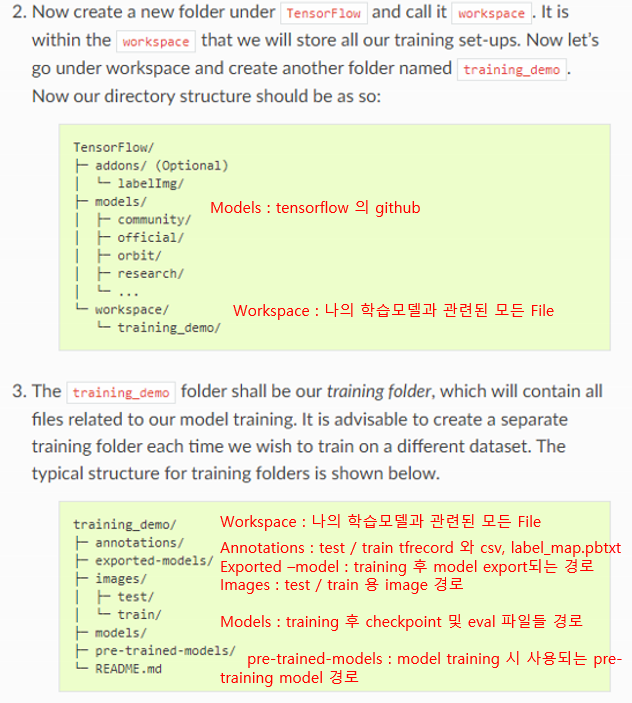
1) object detection 을 위한 tensorflow github download 및 사전 Build test  
2) Dataset 준비   
 - LabelImg 를 통한 image labelling   
 - label 한 image로 tfrecord 만들기  
 - label.pbtxt 생성해두기  
3) Training / Evaluation(eval through Tensorboard)  
4) export model (normal model / tfmodel for each)  
5) 각 모델로 추론해보기 (normal model / tf model test)  
6) tf model 경량화 (진행 중. 내용 확인 필요함)  
 - quantization  
 - prunning   
 - clustering   

# dataset download (이건 test용 dataset으로 별도의 dataset이 있다면 본 구간 Skip

In [1]:
# suspect that we are not ready for well cooked dataset, so skip this
# to download racoon dataset
# !git clone https://github.com/datitran/raccoon_dataset.git

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 652, done.
^Cceiving objects:  65% (424/652), 24.07 MiB | 6.71 MiB/s   


# 1) object detection 을 위한 tensorflow github download 및 사전 Build test

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"


In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.4.1
[]


In [2]:
# Download Tensorflow Object Detection API
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 46614 (delta 23), reused 34 (delta 1), pack-reused 46558
Receiving objects: 100% (46614/46614), 551.44 MiB | 5.43 MiB/s, done.
Resolving deltas: 100% (31992/31992), done.


In [3]:
# Setup APIS
%cd models/research/
!protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install . --use-feature=2020-resolver
%cd ../../
!pwd

/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/models/research
Processing /home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/models/research


/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project
/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project


In [2]:
# test for enviroment is clear, should say ok at the bottom for all test 
!CUDA_VISIBLE_DEVICES=1 python models/research/object_detection/model_lib_tf2_test.py

Running tests under Python 3.7.10: /home001/yousung.choi/anaconda3/envs/tf2/bin/python
[ RUN      ] CheckpointV2Test.test_restore_map_incompatible_error
2021-03-22 16:34:49.426324: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-22 16:34:49.426593: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-03-22 16:34:49.431012: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
INFO:tensorflow:Maybe overwriting train_input_path: models/research/object_detection/test_data/pets_examples.record
I0322 16:34:49.818162 14

INFO:tensorflow:time(__main__.CheckpointV2Test.test_restore_v2): 5.47s
I0322 16:35:14.993177 140691812091648 test_util.py:2076] time(__main__.CheckpointV2Test.test_restore_v2): 5.47s
[       OK ] CheckpointV2Test.test_restore_v2
[ RUN      ] CheckpointV2Test.test_session
[  SKIPPED ] CheckpointV2Test.test_session
[ RUN      ] ModelCheckpointTest.test_checkpoint_max_to_keep
INFO:tensorflow:Maybe overwriting train_input_path: models/research/object_detection/test_data/pets_examples.record
I0322 16:35:15.004760 140691812091648 config_util.py:552] Maybe overwriting train_input_path: models/research/object_detection/test_data/pets_examples.record
INFO:tensorflow:Maybe overwriting eval_input_path: models/research/object_detection/test_data/pets_examples.record
I0322 16:35:15.004904 140691812091648 config_util.py:552] Maybe overwriting eval_input_path: models/research/object_detection/test_data/pets_examples.record
INFO:tensorflow:Maybe overwriting label_map_path: models/research/object_detec

In [6]:
# test for enviroment is clear, should say ok at the bottom for all test 
!CUDA_VISIBLE_DEVICES=1 python models/research/object_detection/exporter_lib_tf2_test.py

2020-11-12 14:24:35.021904: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Running tests under Python 3.7.9: /home/yousungchoi/anaconda3/envs/tf2/bin/python
[ RUN      ] ExportInferenceGraphTest.test_export_checkpoint_and_run_inference_with_image
2020-11-12 14:24:36.232716: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-12 14:24:36.257659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-12 14:24:36.258130: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2020-11-12 14:24:36.258146: I tenso

W1112 14:24:37.331359 140141454509888 save_impl.py:78] Skipping full serialization of Keras layer <__main__.FakeModel object at 0x7f74e031b690>, because it is not built.
INFO:tensorflow:Assets written to: /tmp/exporter_lib_tf2_testugomrdz3/tmpv2d_g_gt/output/saved_model/assets
I1112 14:24:37.379502 140141454509888 builder_impl.py:775] Assets written to: /tmp/exporter_lib_tf2_testugomrdz3/tmpv2d_g_gt/output/saved_model/assets
INFO:tensorflow:Writing pipeline config file to /tmp/exporter_lib_tf2_testugomrdz3/tmpv2d_g_gt/output/pipeline.config
I1112 14:24:37.380869 140141454509888 config_util.py:254] Writing pipeline config file to /tmp/exporter_lib_tf2_testugomrdz3/tmpv2d_g_gt/output/pipeline.config
2020-11-12 14:24:37.423469: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
INFO:tensorflow:time(__main__.ExportInferenceGraphTest.test_export_saved_model_and_run_inference(input_type='image_tensor')): 1.0s
I1112 14:24:38.29274

W1112 14:24:40.056851 140141454509888 save_impl.py:78] Skipping full serialization of Keras layer <__main__.FakeModel object at 0x7f74d024bd90>, because it is not built.
INFO:tensorflow:Assets written to: /tmp/exporter_lib_tf2_testugomrdz3/tmp7b0kgxde/output/saved_model/assets
I1112 14:24:40.108227 140141454509888 builder_impl.py:775] Assets written to: /tmp/exporter_lib_tf2_testugomrdz3/tmp7b0kgxde/output/saved_model/assets
INFO:tensorflow:Writing pipeline config file to /tmp/exporter_lib_tf2_testugomrdz3/tmp7b0kgxde/output/pipeline.config
I1112 14:24:40.109849 140141454509888 config_util.py:254] Writing pipeline config file to /tmp/exporter_lib_tf2_testugomrdz3/tmp7b0kgxde/output/pipeline.config
W1112 14:24:40.141020 140141454509888 def_function.py:120] 5 out of the last 5 calls to <function recreate_function.<locals>.restored_function_body at 0x7f74d035e8c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.fu

# 2) Dataset 준비
 - LabelImg 를 통한 image labelling  (labelimg 로 label 하는 방법은 타 사이트에 많이 나와 있으니 참고)  
 - label 한 image로 tfrecord 만들기  
   -> tfrecord 를 만드는 방법은 두 가지 경로로 가능한데, 첫번째는 아래 generate_tfrecord.py 를 활용하거나  
   -> 그 아래에 있는 source를 활용. 
   ## 단, 두 가지 모두 class_text_to_int 에서 본인이 사용하고자 하는 label 의 enum 값을 변경해야함.
 - label.pbtxt 생성해두기  

# labels
Cursor

In [2]:
%cd workspace/training_demo
!pwd
!python xml_to_csv.py
%cd ../../
!pwd
!mv workspace/training_demo/images/test_labels.csv workspace/training_demo/annotations/test.csv
!mv workspace/training_demo/images/train_labels.csv workspace/training_demo/annotations/train.csv

/home001/yousung.choi/projects/project_coordination/workspace/training_demo
/home001/yousung.choi/projects/project_coordination/workspace/training_demo
Successfully converted xml to csv.
Successfully converted xml to csv.
/home001/yousung.choi/projects/project_coordination
/home001/yousung.choi/projects/project_coordination


# TF record generation
두 가지 방법이 있는데
1) 아래 폴더에 제공된 generate_tfrecord.py 내 class_text_to_int 에 내가 Labeling 한 class들의 이름을 넣어주거나,
2) 아니면 그 아래에 제공한 generate_tfrecord def를 이용하여 generate하거나.

In [3]:
# TF record making
# you can use below 2 ways to generate tf record
# 1) use below command line python 
# 2) use below generate_tfrecord api
# add images in images/train, images/test for each, and *.csv into annotations/ 
%cd workspace/training_demo
!python generate_tfrecord.py --csv_input=annotations/train.csv --image_dir=images/train --output_path=annotations/train.record
!python generate_tfrecord.py --csv_input=annotations/test.csv --image_dir=images/test --output_path=annotations/test.record
%cd ../../
!pwd

/home001/yousung.choi/projects/project_coordination/workspace/training_demo
Successfully created the TFRecords: /home001/yousung.choi/projects/project_coordination/workspace/training_demo/annotations/train.record
version :  2.4.1
Successfully created the TFRecords: /home001/yousung.choi/projects/project_coordination/workspace/training_demo/annotations/test.record
version :  2.4.1
/home001/yousung.choi/projects/project_coordination
/home001/yousung.choi/projects/project_coordination


In [35]:
"""
Usage:
  # From tensorflow/models/
  # Create train data:
  python generate_tfrecord.py --csv_input=data/train_labels.csv  --output_path=train.record

  # Create test data:
  python generate_tfrecord.py --csv_input=data/test_labels.csv  --output_path=test.record
"""
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

# flags = tf.app.flags
# flags.DEFINE_string('csv_input', '', 'Path to the CSV input')
# flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
# flags.DEFINE_string('image_dir', '', 'Path to images')
# FLAGS = flags.FLAGS

# TO-DO replace this with label map
def class_text_to_int(row_label):
    if row_label == 'leashed':
        return 1
#     elif row_label == 'Dog_not_muzzled':
#         return 2
#     elif row_label == 'Dog_leashed':
#         return 3
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def generate_tfrecord(output_path, image_dir, csv_input):
    writer = tf.io.TFRecordWriter(output_path)
    path = os.path.join(image_dir)
    examples = pd.read_csv(csv_input)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), output_path)
    print('Successfully created the TFRecords: {}'.format(output_path))

In [36]:
generate_tfrecord('/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/annotations/test_train.record', '/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/images/train' , '/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/annotations/train.csv')
generate_tfrecord('/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/annotations/test_test.record', '/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/images/test' , '/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/annotations/test.csv')


Successfully created the TFRecords: /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/annotations/test_train.record
Successfully created the TFRecords: /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/annotations/test_test.record


# 3) training / Evaluation
- pre-trained 된 사전 model download
- 내가 학습시키고자 하는 label_map.pbtxt 정립
- pipeline.config 를 이용하여 (본 예제에서는 my_ssd_mobilenet_v2_coco17_tpu-8.config) 학습시키기
- pipeline.config 에서 수정해야 할 변수들 (train_input_config 등) 은 아래 doc 내용 참조.  
 -> https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html?highlight=num_steps#configure-the-training-pipeline  
 -> batch size의 경우는 gpu 의 경우 본인이 사용코자 하는 gpu 의 배수형태여야 함.

In [20]:
#download tensorflow 2 detection pre-trained model
%cd /home/yousungchoi/classes/1_Ambient_computing/99_project/Ambient_project/workspace/training_demo/pre-trained-models
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

/home/yousungchoi/classes/1_Ambient_computing/99_project/Ambient_project/workspace/training_demo/pre-trained-models
--2020-10-30 08:52:18--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 34.64.4.16, 2404:f340:10:1803::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|34.64.4.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  6.55MB/s    in 3.0s    

2020-10-30 08:52:22 (6.55 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]



In [22]:
!tar -xvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!rm -rf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


In [6]:
!cat /home/yousungchoi/projects/project_coordination/workspace/training_demo/annotations/label_map.pbtxt
# Caution!! : this labelmap should be same as what we mentioned in generate_tfrecord.

item {
  id: 1
  name: 'Cursor'
}



In [27]:
!cp /home/yousungchoi/classes/1_Ambient_computing/99_project/Ambient_project/models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config /home/yousungchoi/classes/1_Ambient_computing/99_project/Ambient_project/workspace/training_demo/models
%cd /home/yousungchoi/classes/1_Ambient_computing/99_project/Ambient_project/workspace/training_demo/models
!pwd
!ls
!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config my_ssd_mobilenet_v2_coco17_tpu-8.config
# after copy, change things in below
# num_classes, fine-tune-checkpoint_type, batch_size, num_steps, label_map_path, input_path in train_input_reader, eval_input_reader

/home/yousungchoi/classes/1_Ambient_computing/99_project/Ambient_project/workspace/training_demo/models
/home/yousungchoi/classes/1_Ambient_computing/99_project/Ambient_project/workspace/training_demo/models
1st_trial
my_ssd_mobilenet_v2_coco17_tpu-8.config
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config


In [6]:
# !cat /home/yousungchoi/projects/project_coordination/workspace/training_demo/models/my_ssd_mobilenet_v2_fpnlite_640640.config
!cat /home001/yousung.choi/projects/project_coordination/workspace/training_demo/models/my_ssd_mobilenet_v2_fpnlite_640640.config

# SSD with Mobilenet v2 FPN-lite (go/fpn-lite) feature extractor, shared box
# predictor and focal loss (a mobile version of Retinanet).
# Retinanet: see Lin et al, https://arxiv.org/abs/1708.02002
# Trained on COCO, initialized from Imagenet classification checkpoint
# Train on TPU-8
#
# Achieves 28.2 mAP on COCO17 Val

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 1 #Edited
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      multiscale_anchor_gen

## 빌드기록 남기기
1st : 720 x 1440 Recorded dataset을 640 x 640 resize한 image (image 약 1000개 ) 를 9:1 분할하여 640x640 fpnlite ssd model training\
2nd : 1st에서 활용한 Dataset을 그대로 사용하되, 320x320 fpnlite ssd model training

In [ ]:
%%bash

start=`date +%s`
PIPELINE_CONFIG_PATH='/home/yousungchoi/projects/project_coordination/workspace/training_demo/models/my_ssd_mobilenet_v2_fpnlite_640640.config'
MODEL_DIR='/home/yousungchoi/projects/project_coordination/workspace/training_demo/models/1st_trial'
NUM_TRAIN_STEPS=1000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1
CUDA_VISIBLE_DEVICES=1 python /home/yousungchoi/projects/project_coordination/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --model_dir=${MODEL_DIR} 
#     --checkpoint_dir=${MODEL_DIR}  
#     --num_train_steps=${NUM_TRAIN_STEPS}
end=`date +%s`
runtime=$((end-start))
echo $runtime

#Training sEssion

In [7]:
%%bash

start=`date +%s`
PIPELINE_CONFIG_PATH='/home/yousungchoi/projects/project_coordination/workspace/training_demo/models/my_ssd_mobilenet_v2_fpnlite_640640.config'
MODEL_DIR='/home/yousungchoi/projects/project_coordination/workspace/training_demo/models/1st_trial'
NUM_TRAIN_STEPS=1000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1
CUDA_VISIBLE_DEVICES=1 python /home/yousungchoi/projects/project_coordination/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --model_dir=${MODEL_DIR} \
    --checkpoint_dir=${MODEL_DIR}  
#     --num_train_steps=${NUM_TRAIN_STEPS}
end=`date +%s`
runtime=$((end-start))
echo $runtime

#validation session

Process is terminated.


# 4) export model
- 일반 tf용 model export
- tflite 변환을 위한 model export (두 가지가 다름)
- tflite 용 model export 후 .tflite로 변환하기 위한 command line / python API tool 활용.  
  -> 이 경우에도 둘 중 하나만 하면 됨. (tflite_convert (command line)을 이용한 .tflite 만들기나 / convert.convert 후 file write를 이용한 .tflite 만들기 둘 중 하나 활용하기)

In [6]:
%%bash

start=`date +%s`
# PIPELINE_CONFIG_PATH='/home/yousungchoi/projects/project_coordination/workspace/training_demo/models/my_ssd_mobilenet_v2_fpnlite_640640.config'
# MODEL_DIR='/home/yousungchoi/projects/project_coordination/workspace/training_demo/models/1st_trial'
PIPELINE_CONFIG_PATH='/home/yousungchoi/projects/project_coordination/workspace/training_demo/models/my_ssd_mobilenet_v2_coco17_tpu-8.config'
MODEL_DIR='/home/yousungchoi/projects/project_coordination/workspace/training_demo/models/2nd_tria_320320'
OUTPUT_DIR='/home/yousungchoi/projects/project_coordination/workspace/training_demo/exported-models/2nd_tria_320320'
NUM_TRAIN_STEPS=1000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1
CUDA_VISIBLE_DEVICES=1 python /home/yousungchoi/projects/project_coordination/models/research/object_detection/exporter_main_v2.py \
    --input_type=image_tensor \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --trained_checkpoint_dir=${MODEL_DIR} \
    --output_directory=${OUTPUT_DIR}

end=`date +%s`
runtime=$((end-start))
echo $runtime

# Export Model
# this is upto https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html?highlight=num_steps#configure-the-training-pipeline

29


2020-12-23 07:24:46.257043: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-23 07:24:47.260877: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-12-23 07:24:47.268888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-23 07:24:47.269325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2020-12-23 07:24:47.269339: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-23 07:24:47.270187: I tensorflow/stream_executor/plat

In [7]:
%%bash

start=`date +%s`
PIPELINE_CONFIG_PATH='/home/yousungchoi/projects/project_coordination/workspace/training_demo/exported-models/2nd_tria_320320/pipeline.config'
MODEL_DIR='/home/yousungchoi/projects/project_coordination/workspace/training_demo/exported-models/2nd_tria_320320/checkpoint'
OUTPUT_DIR='/home/yousungchoi/projects/project_coordination/workspace/training_demo/exported-models/2nd_tria_320320/exported_for_tflite'
NUM_TRAIN_STEPS=1000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1
CUDA_VISIBLE_DEVICES=1  python /home/yousungchoi/projects/project_coordination/models/research/object_detection/export_tflite_graph_tf2.py \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --trained_checkpoint_dir=${MODEL_DIR} \
    --output_directory=${OUTPUT_DIR}
    
end=`date +%s`
runtime=$((end-start))
echo $runtime

# Export graph for tflite (frozen graph)
# this is upto https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tf2.md


26


2020-12-23 07:25:25.482984: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-23 07:25:26.490363: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-12-23 07:25:26.498759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-23 07:25:26.499226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2020-12-23 07:25:26.499256: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-23 07:25:26.500152: I tensorflow/stream_executor/plat

# Default converting
Default converting 의 경우 Quantization 이 없기 떄문에 그냥 실행해도 크게 상관없으나, Quantization 이 포함된 경우 Colab을 이용하는 것을 추천 (Tf-nightly)

In [10]:
# test using export_tflite_graph_tf2
import tensorflow as tf

export_dir = "/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/exported-models/4th_trial/exported_for_tflite/saved_model/"
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
with open('/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/exported-models/4th_trial/exported_for_tflite/convered_model.tflite', 'wb') as f:
    f.write(tflite_model)

# below source is for quantization
# converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/my_model')
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]
# tflite_quant_model = converter.convert()
# open("saved_model/my_model.quant.tflite", "wb").write(tflite_quant_model)

In [19]:
# test using export_tflite_graph_tf2
import tensorflow as tf

export_dir = "/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/exported-models/saved_model"
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
with open('/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/exported-models/exported_for_tflite/saved_model/converted_model_from_original.tflite', 'wb') as f:
    f.write(tflite_model)

# doen't work for original model, original model has to be work through export_tflite_graph_tf2.py before change its model to tflite.

ConverterError: <unknown>:0: error: loc("Func/StatefulPartitionedCall/input/_0"): requires all operands and results to have compatible element types
<unknown>:0: note: loc("Func/StatefulPartitionedCall/input/_0"): see current operation: %1 = "tf.Identity"(%arg0) {device = ""} : (tensor<1x?x?x3x!tf.quint8>) -> tensor<1x?x?x3xui8>


In [11]:
%%bash

CUDA_VISIBLE_DEVICES=2 tflite_convert \
  --saved_model_dir='/home/yousungchoi/projects/project_coordination/workspace/training_demo/exported-models/1st_trial/exported_for_tflite/saved_model'\
  --output_file='/home/yousungchoi/projects/project_coordination/workspace/training_demo/exported-models/1st_trial/exported_for_tflite/saved_model/201223_640640_not_quantized.tflite' \
  --experimental_new_converter

2020-12-23 09:12:22.422297: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-23 09:12:23.382142: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-12-23 09:12:23.405605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-23 09:12:23.406053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2020-12-23 09:12:23.406069: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-23 09:12:23.406935: I tensorflow/stream_executor/plat

# Post Quantization
앞서 이야기한대로, Quantization 에는 tf-nightly 가 필요하므로 Colab에서 진행하는 것을 추천

In [1]:
import tensorflow as tf

saved_model_dir = "/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/exported-models/4th_trial/exported_for_tflite"
image_dir = "/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/images/train"
# A generator that provides a representative dataset

dataset_list = tf.data.Dataset.list_files(image_dir + "/*.jpg")

i = 0
for f in dataset_list.take(len(dataset_list)):
    print(i, " ", f)
    i += 1
    

0   tf.Tensor(b'/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/images/train/0032_leashed_dog.jpg', shape=(), dtype=string)
1   tf.Tensor(b'/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/images/train/0200_muzzled_dog.jpg', shape=(), dtype=string)
2   tf.Tensor(b'/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/images/train/0175_muzzled_dog.jpg', shape=(), dtype=string)
3   tf.Tensor(b'/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/images/train/0007_muzzled_dog.jpg', shape=(), dtype=string)
4   tf.Tensor(b'/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/images/train/0003_leashed_dog.jpg', shape=(), dtype=string)
5   tf.Tensor(b'/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Am

(1, 320, 320, 3)


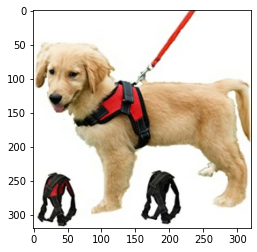

In [4]:
# # Test Code from coral AI (https://github.com/google-coral/tutorials/converting issue.ipynb)
# import matplotlib.pyplot as plt

# saved_model_dir = "/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/exported-models/3rd_trial/exported_for_tflite/saved_model"
# image_dir = "/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/images/train"
# # A generator that provides a representative dataset

# dataset_list = tf.data.Dataset.list_files(image_dir + "/*.jpg")
# image = next(iter(dataset_list))
# image = tf.io.read_file(image)
# image = tf.io.decode_jpeg(image, channels=3)
# image = tf.image.resize(image, [320, 320])
# image = tf.cast(image / 255., tf.float32)
# plt.imshow(image)

# def representative_data_gen():
#   dataset_list = tf.data.Dataset.list_files(image_dir + "/*.jpg")
#   for i in range(len(dataset_list)):
#     image = next(iter(dataset_list))
#     image = tf.io.read_file(image)
#     image = tf.io.decode_jpeg(image, channels=3)
#     image = tf.image.resize(image, [320, 320])
#     image = tf.cast(image / 255., tf.float32)
#     image = tf.expand_dims(image, 0)
#     yield [image]

# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# converter.experimental_new_converter = True

# #################################################
# imported = tf.saved_model.load(saved_model_dir)
# concrete_func = imported.signatures["serving_default"]
# print(concrete_func.inputs[0].get_shape())
# concrete_func.inputs[0].set_shape([1, 320, 320, 3])
# converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
# #################################################

# # This enables quantization
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# # This sets the representative dataset for quantization
# converter.representative_dataset = representative_data_gen
# # This ensures that if any ops can't be quantized, the converter throws an error
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# # For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
# converter.target_spec.supported_types = [tf.int8]
# # These set the input and output tensors to uint8 (added in r2.3)
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8

# tflite_model = converter.convert()

# with open(saved_model_dir + "my_model_quantized_in_int8.tflite", "wb") as f:
#   f.write(tflite_model)

ValueError: Failed to parse the model: pybind11::init(): factory function returned nullptr.

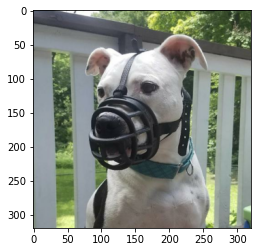

In [2]:
import matplotlib.pyplot as plt

saved_model_dir = "/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/exported-models/5th_trial/exported_for_tflite/saved_model"
image_dir = "/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/images/train"
# A generator that provides a representative dataset

dataset_list = tf.data.Dataset.list_files(image_dir + "/*.jpg")
image = next(iter(dataset_list))
image = tf.io.read_file(image)
image = tf.io.decode_jpeg(image, channels=3)
image = tf.image.resize(image, [320, 320])
image = tf.cast(image / 255., tf.float32)
plt.imshow(image)

def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(image_dir + "/*.jpg")
#   for i in range(len(dataset_list)):
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [320, 320])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.experimental_new_converter = True
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open(saved_model_dir + "my_model_quantized_in_int8_again.tflite", "wb") as f:
  f.write(tflite_model)

In [2]:
!ls /home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/exported-models/3rd_trial/exported_for_tflite/

convered_model.tflite
my_model_quantized_in_int8_edgetpu.html
my_model_quantized_in_int8_edgetpu.log
my_model_quantized_in_int8_edgetpu.tflite
my_model_quantized_in_int8.tflite
saved_model
saved_modelmy_model_quantized_in_int8_again.tflite
visualize.py


In [3]:
!edgetpu_compiler /home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/exported-models/3rd_trial/exported_for_tflite/mine_again.tflite

Edge TPU Compiler version 14.1.317412892

Internal compiler error. Aborting! 


# (Optional) TFLite model 의 in output 정보 살펴보기

In [3]:
# 번외 : tflite model 의 input / output 이 어떤 것인지 살펴보기.
## TFLite Interpreter to check input shape
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
print(input_shape)
print(input_details[0])
print(output_details[0])


[  1 320 320   3]
{'name': 'serving_default_input:0', 'index': 349, 'shape': array([  1, 320, 320,   3], dtype=int32), 'shape_signature': array([  1, 320, 320,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003921568859368563, 0), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:3', 'index': 333, 'shape': array([ 1, 10,  4], dtype=int32), 'shape_signature': array([ 1, 10,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [4]:
!ls

main.ipynb  models  Untitled.ipynb  workspace


In [ ]:
!edgetpu_compiler /home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/exported-models/3rd_trial/exported_for_tflite/saved_modelmy_model_quantized_in_int8.tflite

# 5) 생성한 모델로 추론해보기.
- 본 과정은, 모델을 직접 로딩하여 내가 지목한 사진 파일을 추론해보는 것을 목적으로 두는 것으로서,  
- training / eval 과정 중 생성된 checkpoint 를 활용하여 tensorboard에 얹어 loss 와 추론도 가능함. (tensorboard 활용방법은 다루지 않았음.)
- tensorboard 는 다음과 같은 과정을 통해 serving이 가능함. (tensorboard --logdir="/home/yousungchoi/projects/racoon_test/my_renewal_model" --port=5800![image.png])
## 먼저 일반 tensorflow model 추론


In [3]:
# inference 할 image들의 이름을 변경
import os

file_path = '/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/images/1201_inference_check'

file_names = os.listdir(file_path)
print(len(file_names))

i = 1
for name in file_names:
    src = os.path.join(file_path, name)
    dst = 'images' + str(i) + '.jpg'
    dst = os.path.join(file_path, dst)
    os.rename(src, dst)
    i += 1

42


In [3]:
# Check with exported model and if it is well trained
# these codes are from inference_from_saved_model_tf2_colab.ipynb

import io
import os
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import label_map_util

%matplotlib inline

In [4]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
#   print(im_width, im_height)
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [5]:
# Path to label map file
PATH_TO_LABELS = os.path.join('/home/yousungchoi/projects/project_coordination/workspace/training_demo/annotations','label_map.pbtxt')

# Number of classes the object detector can identify
NUM_CLASSES = 1

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# 1: {'id': 1, 'name': 'book'},
print(category_index)

{1: {'id': 1, 'name': 'Cursor'}}


In [8]:
start_time = time.time()
tf.keras.backend.clear_session()
# detect_fn = tf.saved_model.load('/home/yousungchoi/projects/project_coordination/workspace/training_demo/exported-models/1st_trial/saved_model')
detect_fn = tf.saved_model.load('/home/yousungchoi/projects/project_coordination/workspace/training_demo/exported-models/2nd_tria_320320/saved_model')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 5.945256948471069s


Elapsed time: 0.01184391975402832 second per image
dict_keys(['detection_multiclass_scores', 'detection_anchor_indices', 'detection_boxes', 'raw_detection_scores', 'detection_classes', 'num_detections', 'detection_scores', 'raw_detection_boxes'])


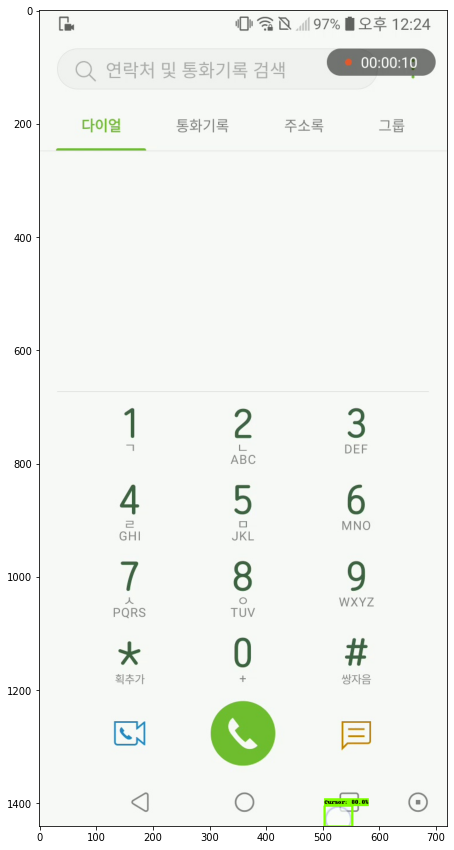

In [83]:
# 특정 파일 명 기반 사진 한장 추론

import os
import random

file_path = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_original_image'
file_names = os.listdir(file_path)

elapsed = []
random.shuffle(file_names)
for i, file in enumerate(file_names):
    if file == 'images0642.jpg':
      image_path = os.path.join(file_path, file)
      image_cv2 = cv2.imread(image_path, cv2.IMREAD_COLOR)
      image_np = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
#       image_np = load_image_into_numpy_array(image_path)
      input_tensor = np.expand_dims(image_np, 0)
      start_time = time.time()
      detections = detect_fn(input_tensor)
      end_time = time.time()
      elapsed.append(end_time - start_time)

      plt.rcParams['figure.figsize'] = [15, 15]
      label_id_offset = 1
      image_np_with_detections = image_np.copy()
      viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'][0].numpy(),
            detections['detection_classes'][0].numpy().astype(np.int32),
            detections['detection_scores'][0].numpy(),
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=.60,
            agnostic_mode=False)
    #   if i == 0 :
    #         print(detections['detection_boxes'][0].numpy(), detections['detection_boxes'][0].shape)
    #         print(detections['detection_scores'][0].numpy())
#       plt.subplot(len(file_names), 1, i+1)
      plt.imshow(image_np_with_detections)

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

print(detections.keys())

100%|██████████| 1049/1049 [00:24<00:00, 42.52it/s]


(1440, 720, 3)
Elapsed time: 0.00934178251346559 second per image
Total obj_cnt :  663
obj_not_cnted :  385
['images0026.jpg', 'images0027.jpg', 'images0031.jpg', 'images0034.jpg', 'images0035.jpg', 'images0036.jpg', 'images0039.jpg', 'images0046.jpg', 'images0047.jpg', 'images0048.jpg', 'images0050.jpg', 'images0052.jpg', 'images0053.jpg', 'images0055.jpg', 'images0056.jpg', 'images0063.jpg', 'images0064.jpg', 'images0066.jpg', 'images0069.jpg', 'images0070.jpg', 'images0071.jpg', 'images0072.jpg', 'images0073.jpg', 'images0076.jpg', 'images0077.jpg', 'images0078.jpg', 'images0087.jpg', 'images0091.jpg', 'images0093.jpg', 'images0094.jpg', 'images0095.jpg', 'images0096.jpg', 'images0105.jpg', 'images0112.jpg', 'images0113.jpg', 'images0114.jpg', 'images0115.jpg', 'images0116.jpg', 'images0117.jpg', 'images0118.jpg', 'images0119.jpg', 'images0120.jpg', 'images0121.jpg', 'images0122.jpg', 'images0123.jpg', 'images0124.jpg', 'images0125.jpg', 'images0130.jpg', 'images0134.jpg', 'images01

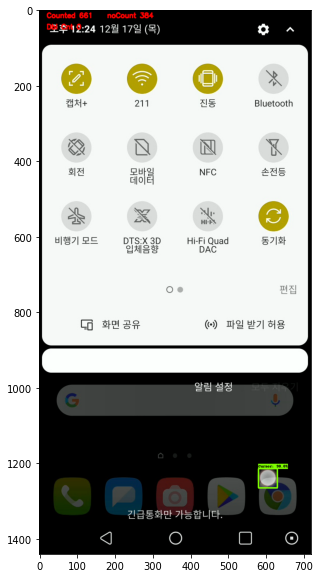

In [9]:
# 읽은 이미지들을 일괄 추론 후 mp4로 변환해서 저장해보자

import os
import random
import cv2
from tqdm import tqdm

file_path = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_original_image'
file_names = os.listdir(file_path)

elapsed = []
obj_cnted_more = []
obj_not_cnted = []
obj_cnt = 0
total_obj_cnt = 0

# setting for Video output
video_output = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_original_image/output_1st_720x1440_320320_model.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(video_output, fourcc, 10.0, (720, 1440))
# random.shuffle(file_names)
file_names.sort()
for i, file in enumerate(tqdm(file_names)):
    if file.endswith('jpg'):
        image_path = os.path.join(file_path, file)
        image_cv2 = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image_np = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
        input_tensor = np.expand_dims(image_np, 0)

        start_time = time.time()
        detections = detect_fn(input_tensor)
        end_time = time.time()
        elapsed.append(end_time - start_time)

        plt.rcParams['figure.figsize'] = [10, 10]
        label_id_offset = 1
        image_np_with_detections = image_cv2.copy()
        viz_utils.visualize_boxes_and_labels_on_image_array(
              image_np_with_detections,
              detections['detection_boxes'][0].numpy(),
              detections['detection_classes'][0].numpy().astype(np.int32),
              detections['detection_scores'][0].numpy(),
              category_index,
              use_normalized_coordinates=True,
              max_boxes_to_draw=200,
              min_score_thresh=.60,
              agnostic_mode=False)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        obj_cnt = len(np.where(detections['detection_scores'][0].numpy() > 0.6)[0])
        total_obj_cnt += obj_cnt
    
        if obj_cnt == 0 :
            obj_not_cnted.append(file)
#             print('No Count!!')
        elif obj_cnt > 1:
            obj_cnted_more.append(file)
#             print('Count more then 2!!')
            
        cv2.putText(image_np_with_detections, 'Counted {0:1d}'.format(total_obj_cnt), (20,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
        cv2.putText(image_np_with_detections, 'noCount {0:1d}'.format(len(obj_not_cnted)), (180,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
        cv2.putText(image_np_with_detections, 'Dbl Cnt {0:1d}'.format(len(obj_cnted_more)), (20,50), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
        
        if i == len(file_names)-5:
            print(image_np_with_detections.shape)
            plt.imshow(image_np_with_detections)
#         elif i == 1001:
#             break

        out.write(image_np_with_detections)
        
out.release()

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

print('Total obj_cnt : ', total_obj_cnt)
print('obj_not_cnted : ', len(obj_not_cnted))
print(obj_not_cnted)
print('obj_cnt_more : ', len(obj_cnted_more))
print(obj_cnted_more)


# print(detections.keys())

In [86]:
# 읽은 동영상을 일괄 추론해서 MP4 로 저장하기

import os
import random
import cv2
from tqdm import tqdm

elapsed = []
obj_cnted_more = []
obj_not_cnted = []
obj_cnt = 0
total_obj_cnt = 0
# setting for Video input
video_input = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/720_1440_V30_201222.mp4'
video_handle = cv2.VideoCapture(video_input)

# setting for Video output
video_output = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/720_1440_V30_201222_output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(video_output, fourcc, 10.0, (720, 1440))

total_frm = np.arange(int(video_handle.get(cv2.CAP_PROP_FRAME_COUNT)))
# print(total_frm)

for frm_cnt in tqdm(total_frm):
    if out.isOpened():
        ret, image_cv2 = video_handle.read()
        if ret:
            image_np = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
            input_tensor = np.expand_dims(image_np, 0)

            start_time = time.time()
            detections = detect_fn(input_tensor)
            end_time = time.time()
            elapsed.append(end_time - start_time)

            plt.rcParams['figure.figsize'] = [20, 20]
            label_id_offset = 1
            image_np_with_detections = image_cv2.copy()
            viz_utils.visualize_boxes_and_labels_on_image_array(
                  image_np_with_detections,
                  detections['detection_boxes'][0].numpy(),
                  detections['detection_classes'][0].numpy().astype(np.int32),
                  detections['detection_scores'][0].numpy(),
                  category_index,
                  use_normalized_coordinates=True,
                  max_boxes_to_draw=200,
                  min_score_thresh=.60,
                  agnostic_mode=False)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            obj_cnt = len(np.where(detections['detection_scores'][0].numpy() > 0.6)[0])
            total_obj_cnt += obj_cnt
    
            if obj_cnt == 0 :
                obj_not_cnted.append(frm_cnt)
                cv2.imwrite('/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/' + 'noobj_images{0:04d}.jpg'.format(frm_cnt), image_np_with_detections)
#                 print('No Count!!')
            elif obj_cnt > 1:
                obj_cnted_more.append(frm_cnt)
                cv2.imwrite('/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/' + 'dbl_images{0:04d}.jpg'.format(frm_cnt), image_np_with_detections)
#                 print('Count more then 2!!')

            cv2.putText(image_np_with_detections, 'Counted {0:1d}'.format(total_obj_cnt), (20,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            cv2.putText(image_np_with_detections, 'noCount {0:1d}'.format(len(obj_not_cnted)), (180,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            cv2.putText(image_np_with_detections, 'Dbl Cnt {0:1d}'.format(len(obj_cnted_more)), (20,50), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)

#             out.write(image_np_with_detections)
        
out.release()

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

print('Total obj_cnt : ', total_obj_cnt)
print('obj_not_cnted : ', len(obj_not_cnted))
print(obj_not_cnted)
print('obj_cnt_more : ', len(obj_cnted_more))
print(obj_cnted_more)



100%|██████████| 604/604 [00:13<00:00, 45.84it/s]

Elapsed time: 0.012152837601718524 second per image
Total obj_cnt :  468
obj_not_cnted :  147
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 79, 80, 81, 82, 148, 149, 150, 168, 169, 170, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 376, 377, 378, 379, 380, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603]
obj_cnt_more :  11
[62, 105, 106, 107, 108, 109, 110, 411, 412, 413, 414]


## 다음은 변환한 tflite 모델 추론

In [17]:
#this is for testing tflite model
# Other imports

import matplotlib
import matplotlib.pyplot as plt

import cv2
import time
import numpy as np

from PIL import Image

In [21]:
#@title TFLite Interpreter and detection utils 
#@markdown Sourced from [here](https://github.com/tensorflow/examples/blob/master/lite/examples/object_detection/raspberry_pi/detect_picamera.py).

def set_input_tensor(interpreter, image):
  """Sets the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Returns the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all output details
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
          'bounding_box': boxes[i],
          'class_id': classes[i],
          'score': scores[i]
      }
      results.append(result)
  return results

def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all output details
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))
  print(count)

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
          'bounding_box': boxes[i],
          'class_id': classes[i],
          'score': scores[i]
      }
      results.append(result)
  return results

In [5]:
!pwd

/home/yousungchoi/projects/project_coordination


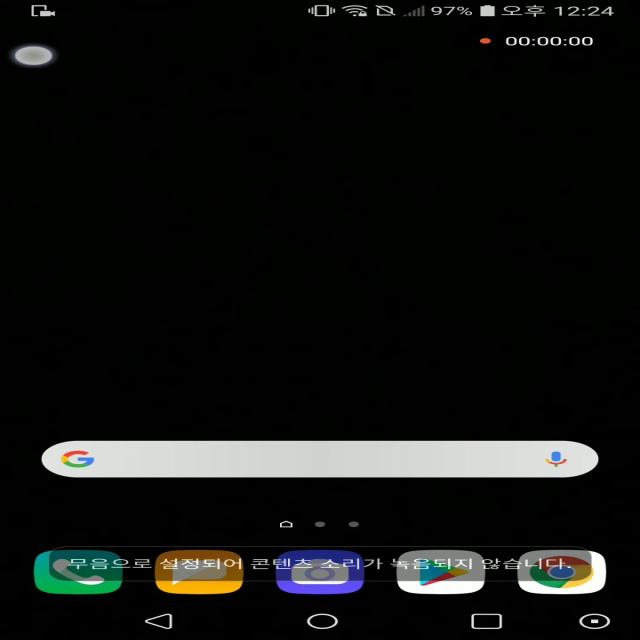

In [6]:
#@title Supply a path to download a relevant image
IMAGE_PATH = "/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/test/images0026_resized_linear.jpg" #@param {type:"string"}

Image.open(IMAGE_PATH)

In [30]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/home/yousungchoi/projects/project_coordination/workspace/training_demo/exported-models/1st_trial/exported_for_tflite/saved_model/201223_640640_quantized.tflite")
# interpreter = tf.lite.Interpreter(model_path="/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/test_model/ssd_mobilenet_v2_320x320_coco17_tpu-8/exported_tflite/quantize_test_ssd.tflite")
interpreter.allocate_tensors()
_, HEIGHT, WIDTH, _ = interpreter.get_input_details()[0]['shape']
print(f"Height and width accepted by the model: {HEIGHT, WIDTH}")
print(interpreter.get_input_details()[0])
print(interpreter.get_output_details()[0].keys())

Height and width accepted by the model: (640, 640)
{'name': 'serving_default_input:0', 'index': 347, 'shape': array([  1, 640, 640,   3], dtype=int32), 'shape_signature': array([  1, 640, 640,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003921568859368563, 0), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
dict_keys(['name', 'index', 'shape', 'shape_signature', 'dtype', 'quantization', 'quantization_parameters', 'sparsity_parameters'])


In [31]:
for i in range(4):
    print(interpreter.get_output_details()[i]['shape'])

[ 1 10  4]
[ 1 10]
[ 1 10]
[1]


In [20]:
print(get_output_tensor(interpreter, 3))

0.0


In [22]:
#@title Image preprocessing utils
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3)
#     img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.convert_image_dtype(img, tf.uint8)
    original_image = img
    resized_img = tf.image.resize(img, (HEIGHT, WIDTH))
    resized_img = resized_img[tf.newaxis, :]
    return resized_img, original_image

In [23]:
#@title Define the label dictionary and color map
LABEL_DICT = {0 : 'cursor',
}

COLORS = np.random.randint(0, 255, size=(len(LABEL_DICT), 3), 
                            dtype="uint8")

In [24]:
#@title Inference utils
def display_results(image_path, threshold=0.6):
    # Load the input image and preprocess it
    preprocessed_image, original_image = preprocess_image(image_path)
    # print(preprocessed_image.shape, original_image.shape)

    # =============Perform inference=====================
    start_time = time.monotonic()
    results = detect_objects(interpreter, preprocessed_image, threshold=threshold)
    print(f"Elapsed time: {(time.monotonic() - start_time)*1000} miliseconds")

    # =============Display the results====================
    original_numpy = original_image.numpy()
    print(results)
    for obj in results:
        # Convert the bounding box figures from relative coordinates
        # to absolute coordinates based on the original resolution
        ymin, xmin, ymax, xmax = obj['bounding_box']
        xmin = int(xmin * original_numpy.shape[1])
        xmax = int(xmax * original_numpy.shape[1])
        ymin = int(ymin * original_numpy.shape[0])
        ymax = int(ymax * original_numpy.shape[0])

        # Grab the class index for the current iteration
        idx = int(obj['class_id'])
        print(idx)
        # Skip the background
        if idx >= len(LABEL_DICT):
            continue

        # draw the bounding box and label on the image
        color = [int(c) for c in COLORS[idx]]
        cv2.rectangle(original_numpy, (xmin, ymin), (xmax, ymax), 
                    color, 2)
        y = ymin - 15 if ymin - 15 > 15 else ymin + 15
        label = "{}: {:.2f}%".format(LABEL_DICT[obj['class_id']],
            obj['score'] * 100)
        cv2.putText(original_numpy, label, (xmin, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return original_numpy
    # return the final ima
#     original_int = (original_numpy * 255).astype(np.uint8)
#     return original_int

10
Elapsed time: 6528.014914016239 miliseconds
[{'bounding_box': array([0.07014494, 0.01657974, 0.10550027, 0.08622088], dtype=float32), 'class_id': 0.0, 'score': 0.96875}]
0


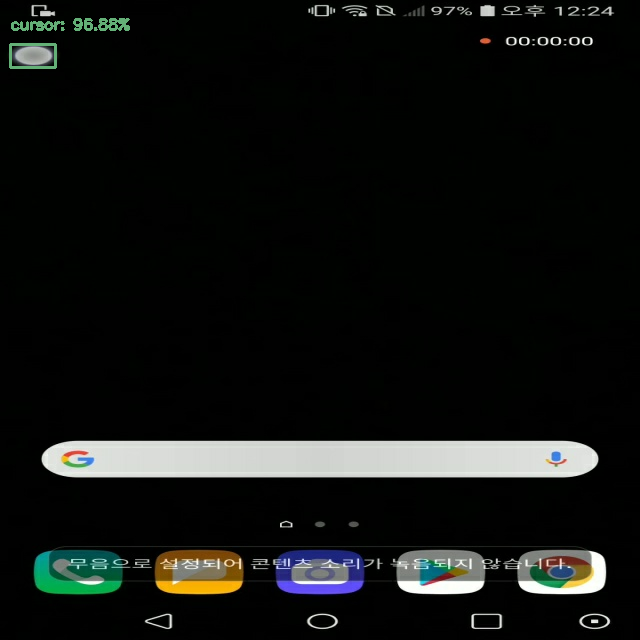

In [25]:
resultant_image = display_results("/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/test/images0026_resized_linear.jpg")
Image.fromarray(resultant_image)

In [57]:
!netron /home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/exported-models/4th_trial/saved_model/saved_model.pb

Serving '/home/yousungchoi/classes/1_Ambient_computing/99_project/2_pretest_Ambient_project/workspace/training_demo/exported-models/4th_trial/saved_model/saved_model.pb' at http://localhost:8080
^C

Stopping http://localhost:8080


In [12]:
#Test 용 Video 만들기

import os
import random
import cv2
from tqdm import tqdm

file_path = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_original_image'
file_names = os.listdir(file_path)

elapsed = []
obj_cnted_more = []
obj_not_cnted = []
obj_cnt = 0
total_obj_cnt = 0

# setting for Video output
video_output = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_original_image/720x1440_Test_Video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(video_output, fourcc, 30.0, (720, 1440))
# random.shuffle(file_names)
file_names.sort()
for i, file in enumerate(tqdm(file_names)):
    if file.endswith('jpg'):
        image_path = os.path.join(file_path, file)
        image_cv2 = cv2.imread(image_path, cv2.IMREAD_COLOR)
#         image_np = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
#         input_tensor = np.expand_dims(image_np, 0)

#         start_time = time.time()
#         detections = detect_fn(input_tensor)
#         end_time = time.time()
#         elapsed.append(end_time - start_time)

#         plt.rcParams['figure.figsize'] = [10, 10]
#         label_id_offset = 1
        image_np_with_detections = image_cv2.copy()
#         viz_utils.visualize_boxes_and_labels_on_image_array(
#               image_np_with_detections,
#               detections['detection_boxes'][0].numpy(),
#               detections['detection_classes'][0].numpy().astype(np.int32),
#               detections['detection_scores'][0].numpy(),
#               category_index,
#               use_normalized_coordinates=True,
#               max_boxes_to_draw=200,
#               min_score_thresh=.60,
#               agnostic_mode=False)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

#         obj_cnt = len(np.where(detections['detection_scores'][0].numpy() > 0.6)[0])
#         total_obj_cnt += obj_cnt
    
#         if obj_cnt == 0 :
#             obj_not_cnted.append(file)
# #             print('No Count!!')
#         elif obj_cnt > 1:
#             obj_cnted_more.append(file)
# #             print('Count more then 2!!')
            
#         cv2.putText(image_np_with_detections, 'Counted {0:1d}'.format(total_obj_cnt), (20,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
#         cv2.putText(image_np_with_detections, 'noCount {0:1d}'.format(len(obj_not_cnted)), (180,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
#         cv2.putText(image_np_with_detections, 'Dbl Cnt {0:1d}'.format(len(obj_cnted_more)), (20,50), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
        
#         if i == len(file_names)-5:
#             print(image_np_with_detections.shape)
#             plt.imshow(image_np_with_detections)
# #         elif i == 1001:
# #             break

        out.write(image_np_with_detections)
        
out.release()

# mean_elapsed = sum(elapsed) / float(len(elapsed))
# print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

# print('Total obj_cnt : ', total_obj_cnt)
# print('obj_not_cnted : ', len(obj_not_cnted))
# print(obj_not_cnted)
# print('obj_cnt_more : ', len(obj_cnted_more))
# print(obj_cnted_more)


# print(detections.keys())

100%|██████████| 1050/1050 [00:10<00:00, 103.32it/s]
